#### By: Peyman Shahidi
#### Created: Oct 9, 2025
#### Last Edit: Oct 24, 2025

<br>

In [149]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [150]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/occWage_vs_taskCount"

In [151]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [152]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop DWA columns
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# # Drop original Task ID and Task Title columns
# ONET = ONET.drop(columns=['Task ID', 'Task Title'])
# # Rename DWA ID and DWA Title to Task ID and Task Title
# ONET = ONET.rename(columns={'DWA ID': 'Task ID', 'DWA Title': 'Task Title'})

# Remove duplicate rows based on Occupation Title and new Task ID
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates(subset=['Occupation Title', 'Task ID']).reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [153]:
# Drop rows with missing wage values and report the impact
print("Removing occupations with missing wage data:")
print("=" * 50)

# Check missing wages before filtering
missing_wages_before = ONET['Hourly_Mean_Wage'].isnull().sum()
total_rows_before = len(ONET)
unique_occupations_before = len(ONET['O*NET-SOC Code'].unique())

print(f"Before filtering:")
print(f"Total rows: {total_rows_before:,}")
print(f"Unique occupations: {unique_occupations_before:,}")
print(f"Missing wage values: {missing_wages_before:,}")
print(f"Percentage missing: {(missing_wages_before / total_rows_before) * 100:.2f}%")

# Drop rows with missing wage values
ONET = ONET.dropna(subset=['Hourly_Mean_Wage'])

# Filter to keep only "Core" task types
rows_after_wage_filter = len(ONET)
print(f"\nAfter wage filtering: {rows_after_wage_filter:,} rows")

print(f"Task Type distribution before filtering:")
print(ONET['Task Type'].value_counts())

ONET = ONET[ONET['Task Type'] == 'Core']

# Report after all filtering
total_rows_after = len(ONET)
print(f"\nAfter filtering (wage + Core tasks only):")
print(f"Total rows: {total_rows_after:,}")
print(f"Rows removed: {total_rows_before - total_rows_after:,}")
print(f"Percentage of data retained: {(total_rows_after / total_rows_before) * 100:.2f}%")

# Check how many unique occupations were affected
unique_occupations_after = len(ONET['O*NET-SOC Code'].unique())
occupations_lost = unique_occupations_before - unique_occupations_after
print(f"\nUnique occupations after filtering: {unique_occupations_after:,}")
print(f"Occupations lost due to missing wages: {occupations_lost:,}")

Removing occupations with missing wage data:
Before filtering:
Total rows: 17,953
Unique occupations: 873
Missing wage values: 434
Percentage missing: 2.42%

After wage filtering: 17,519 rows
Task Type distribution before filtering:
Task Type
Core            12901
Supplemental     4618
Name: count, dtype: int64

After filtering (wage + Core tasks only):
Total rows: 12,901
Rows removed: 5,052
Percentage of data retained: 71.86%

Unique occupations after filtering: 849
Occupations lost due to missing wages: 24


In [154]:
# # Drop original Task ID and Task Title columns
# ONET = ONET.drop(columns=['Task ID', 'Task Title'])
# # Rename DWA ID and DWA Title to Task ID and Task Title
# ONET = ONET.rename(columns={'DWA ID': 'Task ID', 'DWA Title': 'Task Title'})

In [155]:
# Create dataset with selected columns and unique task count
selected_columns = ['O*NET-SOC Code', 'Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Task ID']
onet_filtered = ONET[selected_columns].copy()

# Add unique task count per occupation
task_counts = onet_filtered.groupby('O*NET-SOC Code')['Task ID'].nunique().reset_index()
task_counts.columns = ['O*NET-SOC Code', 'Unique_Task_Count']
occupation_df = onet_filtered.merge(task_counts, on='O*NET-SOC Code', how='left')
occupation_df = occupation_df.drop(columns=['Task ID'])

# Create occupation dataframe
occupation_summary = occupation_df.drop_duplicates(subset=['O*NET-SOC Code', 'Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Unique_Task_Count']).reset_index()
occupation_summary.head()

,index,O*NET-SOC Code,Occupation Title,Hourly_Mean_Wage,Job Zone,Unique_Task_Count
0,0,11-1011.00,Chief Executives,124.47,5,19
1,19,11-1011.03,Chief Sustainability Officers,124.47,5,18
2,37,11-1021.00,General and Operations Managers,62.18,4,9
3,46,11-2011.00,Advertising and Promotions Managers,73.38,4,13
4,59,11-2021.00,Marketing Managers,80.00,4,12


### Plot wages (different percentiles and mean) against job zones and number of unique tasks within occupation

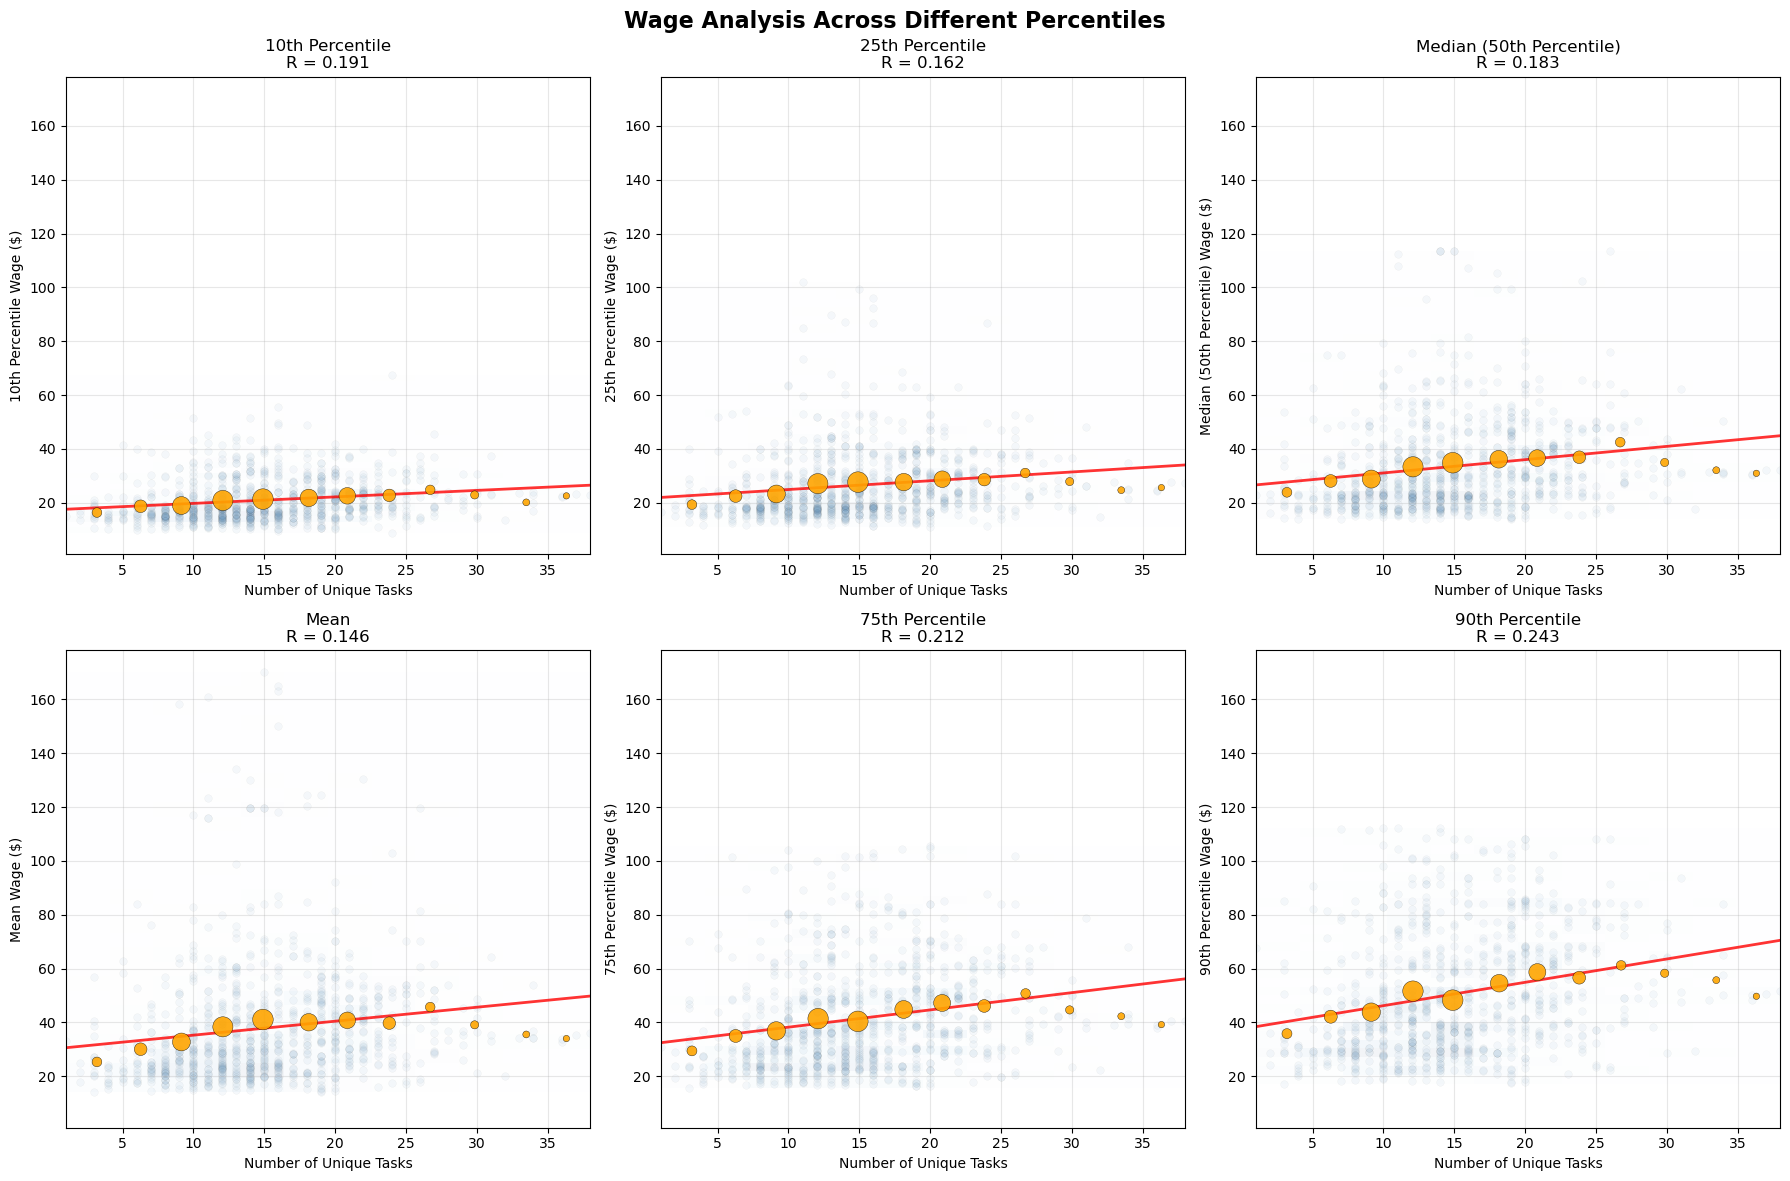

In [156]:
# Analysis using different wage percentiles instead of mean wage
wage_columns = [col for col in ONET.columns if 'Hourly' in col and 'Wage' in col]

# Create occupation summary with all wage percentiles
selected_columns = ['O*NET-SOC Code', 'Occupation Title', 'Job Zone', 'Task ID'] + wage_columns
onet_wage_filtered = ONET[selected_columns].copy()

# Add unique task count per occupation
task_counts = onet_wage_filtered.groupby('O*NET-SOC Code')['Task ID'].nunique().reset_index()
task_counts.columns = ['O*NET-SOC Code', 'Unique_Task_Count']
occupation_wage_df = onet_wage_filtered.merge(task_counts, on='O*NET-SOC Code', how='left')
occupation_wage_df = occupation_wage_df.drop(columns=['Task ID'])

# Create occupation summary with all wage percentiles
occupation_wage_summary = occupation_wage_df.drop_duplicates(
    subset=['O*NET-SOC Code', 'Occupation Title', 'Job Zone', 'Unique_Task_Count'] + wage_columns,
).reset_index(drop=True)

# Define wage percentiles to analyze
wage_percentiles = {
    'Hourly_P10_Wage': '10th Percentile',
    'Hourly_P25_Wage': '25th Percentile', 
    'Hourly_Median_Wage': 'Median (50th Percentile)',
    'Hourly_Mean_Wage': 'Mean',
    'Hourly_P75_Wage': '75th Percentile',
    'Hourly_P90_Wage': '90th Percentile'
}

# Filter for available wage columns
available_percentiles = {col: desc for col, desc in wage_percentiles.items() if col in occupation_wage_summary.columns}

# Calculate global y-axis limits for consistent scaling across all wage plots
all_wage_values = []
for wage_col in available_percentiles.keys():
    clean_data = occupation_wage_summary[wage_col].dropna()
    if len(clean_data) > 0:
        all_wage_values.extend(clean_data.values)

if all_wage_values:
    global_y_min = min(all_wage_values)
    global_y_max = max(all_wage_values)
    # Add some padding for better visualization
    y_padding = (global_y_max - global_y_min) * 0.05
    global_y_min = max(0, global_y_min - y_padding)  # Don't go below 0 for wages
    global_y_max = global_y_max + y_padding
else:
    global_y_min, global_y_max = 0, 100  # Default values

# Create comprehensive analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Wage Analysis Across Different Percentiles', fontsize=16, fontweight='bold')

for idx, (wage_col, wage_desc) in enumerate(available_percentiles.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Remove missing values for this wage column
    clean_data = occupation_wage_summary[['Unique_Task_Count', 'Job Zone', wage_col]].dropna()
    
    if len(clean_data) == 0:
        ax.text(0.5, 0.5, f'No data available\nfor {wage_desc}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{wage_desc}\n(No Data)')
        ax.set_ylim(global_y_min, global_y_max)
        continue
    
    # Prepare x/y arrays
    x = clean_data['Unique_Task_Count'].values
    y = clean_data[wage_col].values

    # Create low-opacity 2D binned background (pcolormesh) to show density
    try:
        # Use ~12 bins on x axis (13 edges) per user request
        bins_x = np.linspace(x.min(), x.max(), 13)
        bins_y = np.linspace(y.min(), y.max(), 30)
        H, xedges, yedges = np.histogram2d(x, y, bins=[bins_x, bins_y])
        X, Y = np.meshgrid(xedges, yedges)
        # Very low opacity background for the bins
        ax.pcolormesh(X, Y, H.T, cmap=plt.cm.Blues, alpha=0.05, shading='auto')

        # Compute 1D x-bin averages (each overlaid point represents the average of nearby x values)
        bin_mean_x = []
        bin_mean_y = []
        bin_counts = []
        for i in range(len(bins_x) - 1):
            mask_bin = (x >= bins_x[i]) & (x < bins_x[i + 1])
            cnt = int(mask_bin.sum())
            if cnt > 0:
                bin_mean_x.append(x[mask_bin].mean())
                bin_mean_y.append(y[mask_bin].mean())
                bin_counts.append(cnt)

        bin_mean_x = np.array(bin_mean_x)
        bin_mean_y = np.array(bin_mean_y)
        bin_counts = np.array(bin_counts)
        # size scale for visibility
        if len(bin_counts) > 0:
            sizes = (bin_counts - bin_counts.min() + 1) / (bin_counts.max() - bin_counts.min() + 1) * 200 + 20
        else:
            sizes = np.array([])
    except Exception:
        # Fallback: no bin background if something fails
        bin_mean_x = np.array([])
        bin_mean_y = np.array([])
        sizes = np.array([])

    # Scatter plot: Tasks vs Wage (raw points)
    ax.scatter(clean_data['Unique_Task_Count'], clean_data[wage_col], 
               alpha=0.05, s=30, color='steelblue', edgecolor='black', linewidth=0.3)

    # Calculate correlation and add trend line
    correlation = clean_data['Unique_Task_Count'].corr(clean_data[wage_col])
    
    if not pd.isna(correlation):
        z = np.polyfit(clean_data['Unique_Task_Count'], clean_data[wage_col], 1)
        p = np.poly1d(z)
        x_line = np.linspace(clean_data['Unique_Task_Count'].min(), clean_data['Unique_Task_Count'].max(), 100)
        ax.plot(x_line, p(x_line), 'r-', alpha=0.8, linewidth=2)
    
    # Overlay bin-averaged scatter points (each point = average y for nearby x values)
    if len(bin_mean_x) > 0:
        ax.scatter(bin_mean_x, bin_mean_y, s=sizes, color='orange', alpha=0.9,
                   edgecolor='black', linewidth=0.3, zorder=5)

    ax.set_xlabel('Number of Unique Tasks')
    ax.set_ylabel(f'{wage_desc} Wage ($)')
    ax.set_title(f'{wage_desc}\nR = {correlation:.3f}' if not pd.isna(correlation) else f'{wage_desc}\n(No correlation)')
    ax.set_ylim(global_y_min, global_y_max)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
# Make sure output directory exists
os.makedirs(f'{output_plot_path}', exist_ok=True)
plt.savefig(f'{output_plot_path}/occWage_vs_taskCount.png', dpi=300)
plt.show()


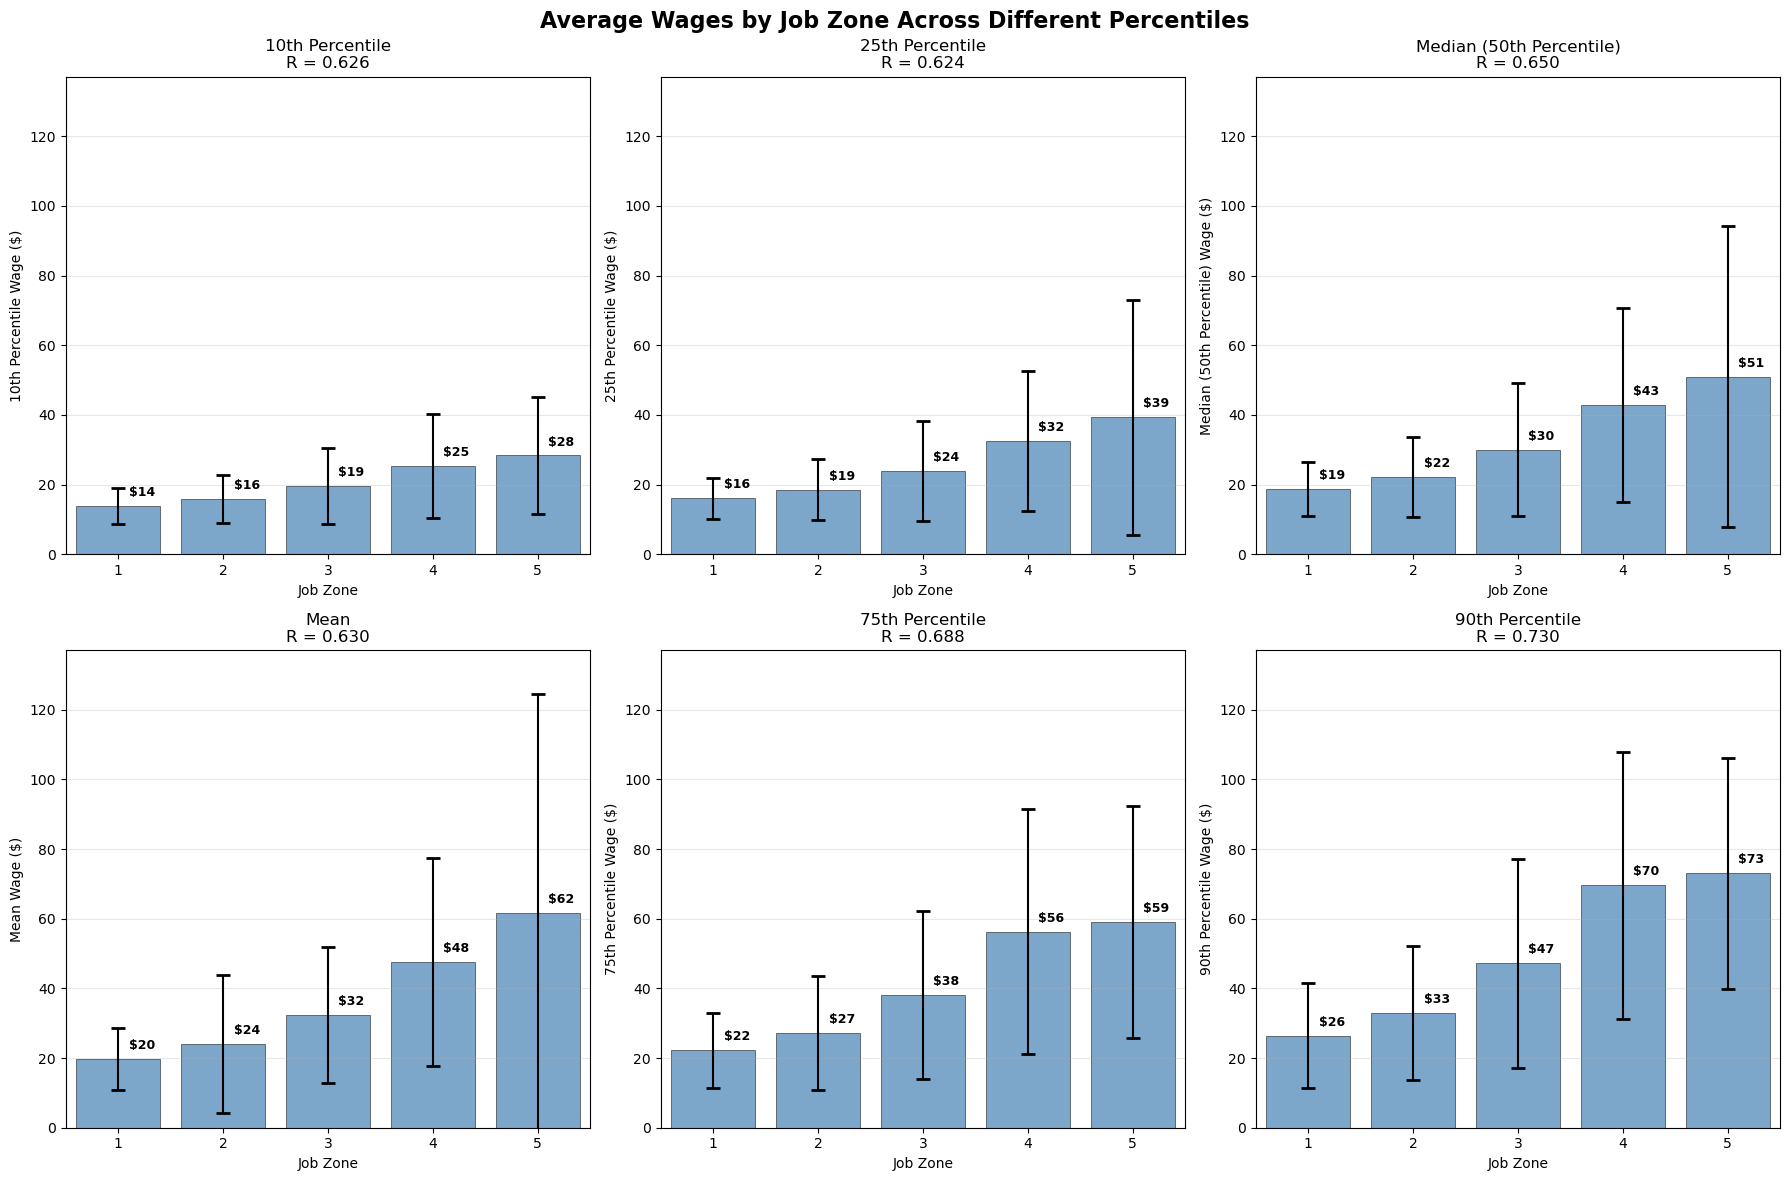

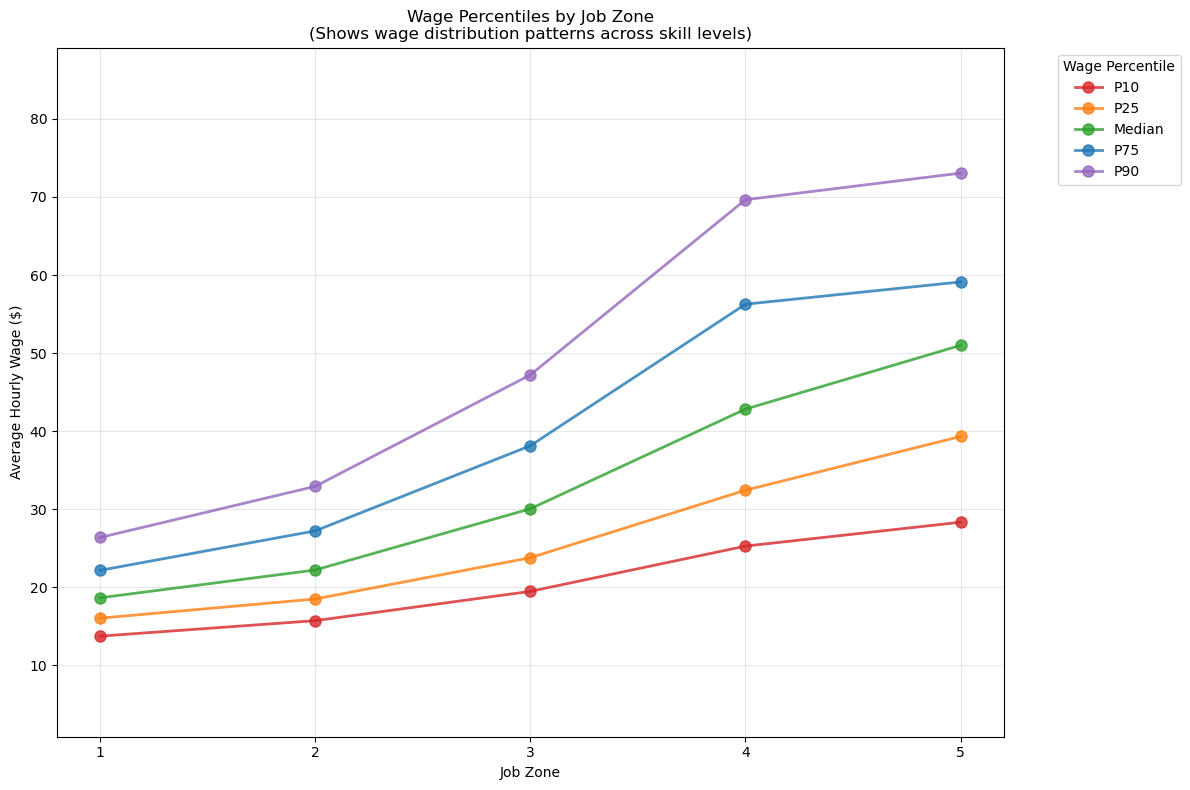

In [157]:
# Create wage by job zone plots for different percentiles
available_percentiles = {
    'Hourly_P10_Wage': '10th Percentile',
    'Hourly_P25_Wage': '25th Percentile', 
    'Hourly_Median_Wage': 'Median (50th Percentile)',
    'Hourly_Mean_Wage': 'Mean',
    'Hourly_P75_Wage': '75th Percentile',
    'Hourly_P90_Wage': '90th Percentile'
}

# Filter for existing columns in the dataset
available_percentiles = {col: desc for col, desc in available_percentiles.items() 
                        if col in occupation_wage_summary.columns}

# Calculate y-axis limits for bar charts (including error bars)
all_bar_values = []
for wage_col in available_percentiles.keys():
    clean_data = occupation_wage_summary[['Job Zone', wage_col]].dropna()
    if len(clean_data) > 0:
        job_zones = sorted(clean_data['Job Zone'].unique())
        for zone in job_zones:
            zone_data = clean_data[clean_data['Job Zone'] == zone]
            zone_mean = zone_data[wage_col].mean()
            zone_std = zone_data[wage_col].std()
            # Include the maximum possible value with error bar
            all_bar_values.append(zone_mean + (1.96 * zone_std if not pd.isna(zone_std) else 0))
            all_bar_values.append(zone_mean)

if all_bar_values:
    bar_y_max = max(all_bar_values)
    bar_y_min = 0  # Start bars from 0
    # Add padding for labels above bars
    bar_y_max = bar_y_max * 1.1
else:
    bar_y_min, bar_y_max = 0, 100

# Create subplots for wage by job zone analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Average Wages by Job Zone Across Different Percentiles', fontsize=16, fontweight='bold')

for idx, (wage_col, wage_desc) in enumerate(available_percentiles.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Calculate mean and standard deviation for each job zone for this wage percentile
    clean_data = occupation_wage_summary[['Job Zone', wage_col]].dropna()
    
    if len(clean_data) == 0:
        ax.text(0.5, 0.5, f'No data available\nfor {wage_desc}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{wage_desc}\n(No Data)')
        ax.set_ylim(bar_y_min, bar_y_max)
        continue
    
    job_zones = sorted(clean_data['Job Zone'].unique())
    zone_means = []
    zone_stds = []
    
    for zone in job_zones:
        zone_data = clean_data[clean_data['Job Zone'] == zone]
        zone_means.append(zone_data[wage_col].mean())
        zone_stds.append(zone_data[wage_col].std())
    
    # Create bar plot with error bars (1.96 * std for 95% confidence interval)
    error_bars = [1.96 * std if not pd.isna(std) else 0 for std in zone_stds]
    
    bars = ax.bar(job_zones, zone_means, alpha=0.7, color='steelblue', 
                  edgecolor='black', linewidth=0.5)
    ax.errorbar(job_zones, zone_means, yerr=error_bars, fmt='none', 
               color='black', capsize=5, capthick=2)
    
    # Add value labels on top of bars
    for i, (zone, mean) in enumerate(zip(job_zones, zone_means)):
        ax.text(zone + 0.1, mean + 2, f'${mean:.0f}', 
               ha='left', va='bottom', fontweight='bold', fontsize=9)
    
    # Calculate correlation between job zone and this wage percentile
    correlation = clean_data['Job Zone'].corr(clean_data[wage_col])
    
    ax.set_xlabel('Job Zone')
    ax.set_ylabel(f'{wage_desc} Wage ($)')
    ax.set_title(f'{wage_desc}\nR = {correlation:.3f}' if not pd.isna(correlation) else f'{wage_desc}\n(No correlation)')
    ax.set_ylim(bar_y_min, bar_y_max)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set consistent x-axis
    ax.set_xlim(0.5, 5.5)
    ax.set_xticks(job_zones)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/occWage_vs_jobZone1.png', dpi=300)
plt.show()

# Create a summary comparison plot showing wage ranges by job zone
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Select key percentiles for range visualization
key_percentiles = ['Hourly_P10_Wage', 'Hourly_P25_Wage', 'Hourly_Median_Wage', 
                   'Hourly_P75_Wage', 'Hourly_P90_Wage']
existing_key_percentiles = [col for col in key_percentiles if col in occupation_wage_summary.columns]

# Create wage ranges for each job zone
job_zones = sorted(occupation_wage_summary['Job Zone'].unique())
x_positions = np.arange(len(job_zones))

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd']

for i, percentile in enumerate(existing_key_percentiles):
    zone_values = []
    for zone in job_zones:
        zone_data = occupation_wage_summary[occupation_wage_summary['Job Zone'] == zone]
        zone_mean = zone_data[percentile].mean()
        zone_values.append(zone_mean)
    
    percentile_label = {
        'Hourly_P10_Wage': 'P10',
        'Hourly_P25_Wage': 'P25',
        'Hourly_Median_Wage': 'Median',
        'Hourly_P75_Wage': 'P75',
        'Hourly_P90_Wage': 'P90'
    }
    
    ax.plot(x_positions, zone_values, 'o-', color=colors[i % len(colors)], 
           linewidth=2, markersize=8, label=percentile_label.get(percentile, percentile),
           alpha=0.8)

ax.set_xlabel('Job Zone')
ax.set_ylabel('Average Hourly Wage ($)')
ax.set_title('Wage Percentiles by Job Zone\n(Shows wage distribution patterns across skill levels)')
ax.set_xticks(x_positions)
ax.set_xticklabels(job_zones)
ax.set_ylim(global_y_min, global_y_max/2)  # Use the same global scale
ax.legend(title='Wage Percentile', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/occWage_vs_jobZone2.png', dpi=300)
plt.show()

### Repeat the same analysis but with reshuffled data

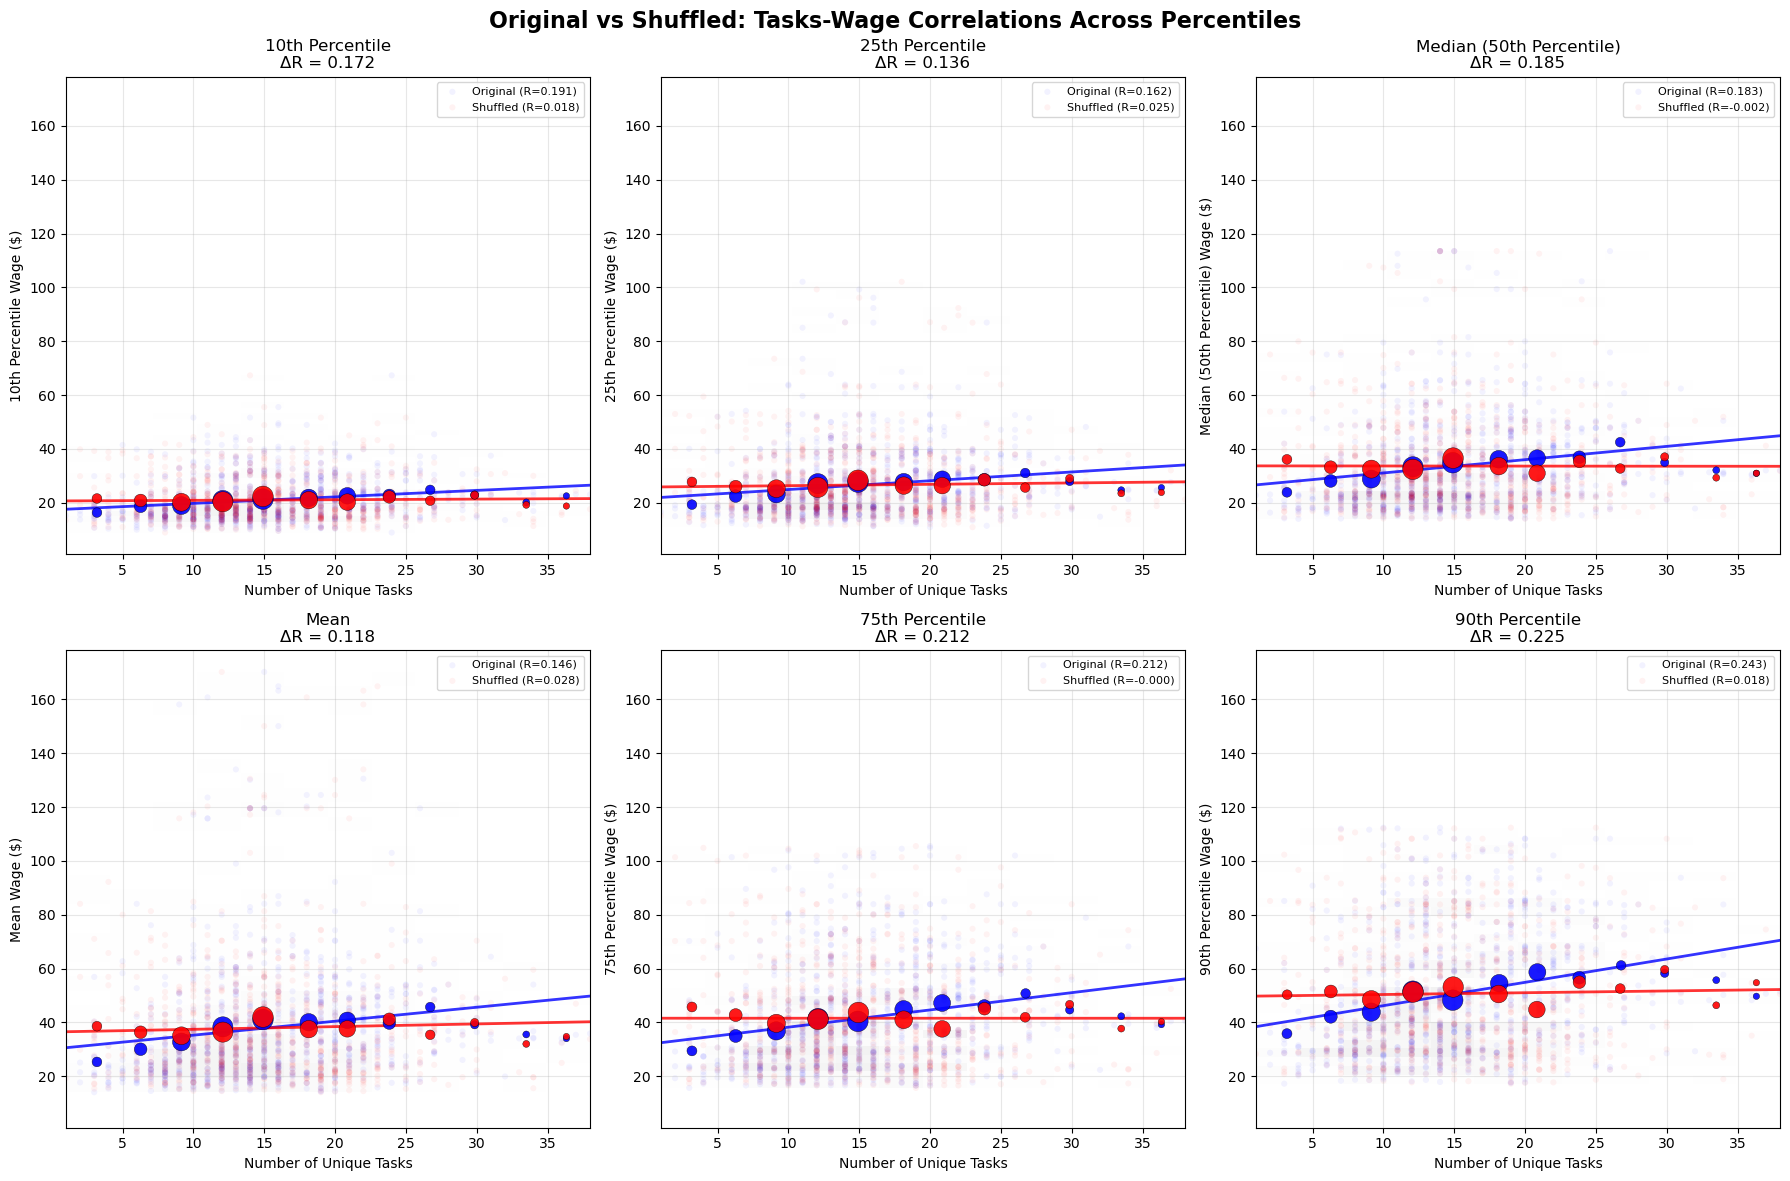

In [158]:
# Shuffled analysis using different wage percentiles
import numpy as np
np.random.seed(42)  # For reproducibility

# Get available wage columns from the original occupation_wage_summary
wage_columns = [col for col in ONET.columns if 'Hourly' in col and 'Wage' in col]
available_percentiles = {
    'Hourly_P10_Wage': '10th Percentile',
    'Hourly_P25_Wage': '25th Percentile', 
    'Hourly_Median_Wage': 'Median (50th Percentile)',
    'Hourly_Mean_Wage': 'Mean',
    'Hourly_P75_Wage': '75th Percentile',
    'Hourly_P90_Wage': '90th Percentile'
}

# Filter for existing columns in the dataset
available_percentiles = {col: desc for col, desc in available_percentiles.items() 
                        if col in occupation_wage_summary.columns}

# Create shuffled version where we permute the ENTIRE wage distributions
shuffled_wage_data = occupation_wage_summary.copy()

# Get all wage columns
wage_cols = [col for col in occupation_wage_summary.columns if 'Hourly' in col and 'Wage' in col]

# Create indices for shuffling
n_occupations = len(occupation_wage_summary)
shuffled_indices = np.random.permutation(n_occupations)

# Shuffle all wage columns together using the same permutation
for wage_col in wage_cols:
    shuffled_wage_data[wage_col] = occupation_wage_summary[wage_col].iloc[shuffled_indices].values

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Original vs Shuffled: Tasks-Wage Correlations Across Percentiles', fontsize=16, fontweight='bold')

for idx, (wage_col, wage_desc) in enumerate(available_percentiles.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Get clean data for both original and shuffled
    clean_original = occupation_wage_summary[['Unique_Task_Count', wage_col]].dropna()
    clean_shuffled = shuffled_wage_data[['Unique_Task_Count', wage_col]].dropna()
    
    if len(clean_original) == 0 or len(clean_shuffled) == 0:
        ax.text(0.5, 0.5, f'No data available\nfor {wage_desc}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{wage_desc}\n(No Data)')
        ax.set_ylim(global_y_min, global_y_max)
        continue
    
    # Calculate correlations
    original_corr = clean_original['Unique_Task_Count'].corr(clean_original[wage_col])
    shuffled_corr = clean_shuffled['Unique_Task_Count'].corr(clean_shuffled[wage_col])
    
    # Plot both original and shuffled data
    ax.scatter(clean_original['Unique_Task_Count'], clean_original[wage_col], 
               alpha=0.05, s=20, color='blue', label=f'Original (R={original_corr:.3f})', edgecolor='none')
    ax.scatter(clean_shuffled['Unique_Task_Count'], clean_shuffled[wage_col], 
               alpha=0.05, s=20, color='red', label=f'Shuffled (R={shuffled_corr:.3f})', edgecolor='none')

    # Add a low-opacity combined bin background to show overall density
    try:
        x_comb = np.concatenate([clean_original['Unique_Task_Count'].values, clean_shuffled['Unique_Task_Count'].values])
        y_comb = np.concatenate([clean_original[wage_col].values, clean_shuffled[wage_col].values])
        bins_x = np.linspace(x_comb.min(), x_comb.max(), 13)
        bins_y = np.linspace(y_comb.min(), y_comb.max(), 30)
        Hc, xedges_c, yedges_c = np.histogram2d(x_comb, y_comb, bins=[bins_x, bins_y])
        Xc, Yc = np.meshgrid(xedges_c, yedges_c)
        ax.pcolormesh(Xc, Yc, Hc.T, cmap=plt.cm.Greys, alpha=0.05, shading='auto')
    except Exception:
        pass

    # Add trend lines
    if not pd.isna(original_corr):
        z_orig = np.polyfit(clean_original['Unique_Task_Count'], clean_original[wage_col], 1)
        p_orig = np.poly1d(z_orig)
        x_line_orig = np.linspace(clean_original['Unique_Task_Count'].min(), clean_original['Unique_Task_Count'].max(), 100)
        ax.plot(x_line_orig, p_orig(x_line_orig), 'b-', alpha=0.8, linewidth=2)

    if not pd.isna(shuffled_corr):
        z_shuf = np.polyfit(clean_shuffled['Unique_Task_Count'], clean_shuffled[wage_col], 1)
        p_shuf = np.poly1d(z_shuf)
        x_line_shuf = np.linspace(clean_shuffled['Unique_Task_Count'].min(), clean_shuffled['Unique_Task_Count'].max(), 100)
        ax.plot(x_line_shuf, p_shuf(x_line_shuf), 'r-', alpha=0.8, linewidth=2)
    
    # Compute per-x-bin averages for original and shuffled and overlay them
    try:
        bins_x = np.linspace(min(clean_original['Unique_Task_Count'].min(), clean_shuffled['Unique_Task_Count'].min()),
                             max(clean_original['Unique_Task_Count'].max(), clean_shuffled['Unique_Task_Count'].max()),
                             13)
        # Original
        orig_mean_x = []
        orig_mean_y = []
        orig_counts = []
        for i in range(len(bins_x) - 1):
            mask_o = (clean_original['Unique_Task_Count'].values >= bins_x[i]) & (clean_original['Unique_Task_Count'].values < bins_x[i+1])
            cnt_o = int(mask_o.sum())
            if cnt_o > 0:
                orig_mean_x.append(clean_original['Unique_Task_Count'].values[mask_o].mean())
                orig_mean_y.append(clean_original[wage_col].values[mask_o].mean())
                orig_counts.append(cnt_o)
        orig_mean_x = np.array(orig_mean_x)
        orig_mean_y = np.array(orig_mean_y)
        orig_counts = np.array(orig_counts)
        if len(orig_counts) > 0:
            orig_sizes = (orig_counts - orig_counts.min() + 1) / (orig_counts.max() - orig_counts.min() + 1) * 200 + 20
        else:
            orig_sizes = np.array([])

        # Shuffled
        shuf_mean_x = []
        shuf_mean_y = []
        shuf_counts = []
        for i in range(len(bins_x) - 1):
            mask_s = (clean_shuffled['Unique_Task_Count'].values >= bins_x[i]) & (clean_shuffled['Unique_Task_Count'].values < bins_x[i+1])
            cnt_s = int(mask_s.sum())
            if cnt_s > 0:
                shuf_mean_x.append(clean_shuffled['Unique_Task_Count'].values[mask_s].mean())
                shuf_mean_y.append(clean_shuffled[wage_col].values[mask_s].mean())
                shuf_counts.append(cnt_s)
        shuf_mean_x = np.array(shuf_mean_x)
        shuf_mean_y = np.array(shuf_mean_y)
        shuf_counts = np.array(shuf_counts)
        if len(shuf_counts) > 0:
            shuf_sizes = (shuf_counts - shuf_counts.min() + 1) / (shuf_counts.max() - shuf_counts.min() + 1) * 200 + 20
        else:
            shuf_sizes = np.array([])

        # Overlay bin-averaged points with high opacity as requested
        if len(orig_mean_x) > 0:
            ax.scatter(orig_mean_x, orig_mean_y, s=orig_sizes, color='blue', alpha=0.9, edgecolor='black', linewidth=0.3, zorder=6)
        if len(shuf_mean_x) > 0:
            ax.scatter(shuf_mean_x, shuf_mean_y, s=shuf_sizes, color='red', alpha=0.9, edgecolor='black', linewidth=0.3, zorder=6)
    except Exception:
        pass

    ax.set_xlabel('Number of Unique Tasks')
    ax.set_ylabel(f'{wage_desc} Wage ($)')
    ax.set_title(f'{wage_desc}\nΔR = {original_corr - shuffled_corr:.3f}')
    ax.set_ylim(global_y_min, global_y_max)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
# Make sure output directory exists
os.makedirs(f'{output_plot_path}/sanityCheck', exist_ok=True)
plt.savefig(f'{output_plot_path}/sanityCheck/occWage_vs_taskCount_sanity.png', dpi=300)
plt.show()


In [159]:
# Regression analysis: save statsmodels text summaries and coefficient CSVs (no plots)
# Two specs per percentile:
# 1) wage ~ Unique_Task_Count
# 2) wage ~ Unique_Task_Count + MajorGroup fixed effects (if available)

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Identify wage percentile columns (reuse same logic as above)
wage_percentiles = [
    'Hourly_P10_Wage', 'Hourly_P25_Wage', 'Hourly_Median_Wage',
    'Hourly_Mean_Wage', 'Hourly_P75_Wage', 'Hourly_P90_Wage'
]
available_wages = [col for col in wage_percentiles if col in occupation_wage_summary.columns]

# Try to find a Major Group code column in the data
possible_major_cols = ['Major Group Code','Major_Group_Code','Major Group','Major_Group','MajorGroupCode','MajorGroup','MajorGroupCode']
major_col = None
for c in possible_major_cols:
    if c in occupation_wage_summary.columns:
        major_col = c
        break

# If not found in occupation_wage_summary, check the original ONET and merge if needed
if major_col is None:
    for c in possible_major_cols:
        if c in ONET.columns:
            if 'O*NET-SOC Code' in occupation_wage_summary.columns and 'O*NET-SOC Code' in ONET.columns:
                tmp = ONET[['O*NET-SOC Code', c]].drop_duplicates(subset='O*NET-SOC Code')
                occupation_wage_summary = occupation_wage_summary.merge(tmp, on='O*NET-SOC Code', how='left')
                if c in occupation_wage_summary.columns:
                    major_col = c
                    break

print(f"Detected Major Group column: {major_col}")

# Prepare output directory
os.makedirs(f"{output_data_path}", exist_ok=True)

# where to save model text and csv outputs
out_dir = f"{output_plot_path}/regression_outputs"
os.makedirs(out_dir, exist_ok=True)

saved_files = []

for wage_col in available_wages:
    # Prepare base dataframe
    cols_needed = ['Unique_Task_Count', wage_col]
    if major_col is not None:
        cols_needed.append(major_col)
    df = occupation_wage_summary[cols_needed].dropna()

    # Skip small samples but still write a small note file
    if len(df) < 10:
        note_path = f"{out_dir}/{wage_col}_note.txt"
        with open(note_path, 'w') as f:
            f.write(f"Too few observations to run regressions for {wage_col} (n={len(df)})\n")
            f.write('No models run.')
        saved_files.append(note_path)
        continue

    # Model 1: tasks only
    try:
        model1 = smf.ols(f"{wage_col} ~ Unique_Task_Count", data=df).fit()

        # Save text summary
        txt_path1 = f"{out_dir}/{wage_col}_tasks_only_summary.txt"
        with open(txt_path1, 'w') as f:
            f.write(model1.summary().as_text())
        saved_files.append(txt_path1)

        # Build coefficient table and save as CSV
        ci1 = model1.conf_int()
        coef_table1 = pd.DataFrame({
            'coef': model1.params,
            'se': model1.bse,
            't': model1.tvalues,
            'p': model1.pvalues,
        })
        # add conf ints
        coef_table1['ci_lower'] = ci1[0]
        coef_table1['ci_upper'] = ci1[1]
        csv_path1 = f"{out_dir}/{wage_col}_tasks_only_params.csv"
        coef_table1.to_csv(csv_path1)
        saved_files.append(csv_path1)

    except Exception as e:
        err_path = f"{out_dir}/{wage_col}_tasks_only_error.txt"
        with open(err_path, 'w') as f:
            f.write(f"Model 1 (tasks only) failed for {wage_col}: {e}\n")
        saved_files.append(err_path)

    # Model 2: tasks + MajorGroup FE
    if major_col is not None and df[major_col].nunique() > 1:
        df2 = df.copy()
        df2['_MAJOR_FE'] = df2[major_col].astype('category')
        try:
            model2 = smf.ols(f"{wage_col} ~ Unique_Task_Count + C(_MAJOR_FE)", data=df2).fit()

            # Save text summary
            txt_path2 = f"{out_dir}/{wage_col}_tasks_plus_majorFE_summary.txt"
            with open(txt_path2, 'w') as f:
                f.write(model2.summary().as_text())
            saved_files.append(txt_path2)

            # Build coefficient table and save as CSV (only parameters present in model)
            ci2 = model2.conf_int()
            coef_table2 = pd.DataFrame({
                'coef': model2.params,
                'se': model2.bse,
                't': model2.tvalues,
                'p': model2.pvalues,
            })
            # add conf ints where available
            if 'Unique_Task_Count' in ci2.index:
                coef_table2['ci_lower'] = ci2[0]
                coef_table2['ci_upper'] = ci2[1]
            else:
                coef_table2['ci_lower'] = np.nan
                coef_table2['ci_upper'] = np.nan

            csv_path2 = f"{out_dir}/{wage_col}_tasks_plus_majorFE_params.csv"
            coef_table2.to_csv(csv_path2)
            saved_files.append(csv_path2)

        except Exception as e:
            err_path = f"{out_dir}/{wage_col}_tasks_plus_majorFE_error.txt"
            with open(err_path, 'w') as f:
                f.write(f"Model 2 (tasks + MajorGroup FE) failed for {wage_col}: {e}\n")
            saved_files.append(err_path)
    else:
        note_path = f"{out_dir}/{wage_col}_tasks_plus_majorFE_note.txt"
        with open(note_path, 'w') as f:
            f.write(f"Major Group column not available or has single group; FE model not run for {wage_col}.\n")
        saved_files.append(note_path)

# Optionally save an index of files created
index_path = f"{out_dir}/_index_of_saved_files.txt"
with open(index_path, 'w') as f:
    f.write('\n'.join(saved_files))

print('Saved regression outputs:')
for p in saved_files:
    print(' -', p)

print(f'All outputs located in: {out_dir}')

Detected Major Group column: Major_Group_Code
Saved regression outputs:
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P10_Wage_tasks_only_summary.txt
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P10_Wage_tasks_only_params.csv
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P10_Wage_tasks_plus_majorFE_summary.txt
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P10_Wage_tasks_plus_majorFE_params.csv
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P25_Wage_tasks_only_summary.txt
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P25_Wage_tasks_only_params.csv
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P25_Wage_tasks_plus_majorFE_summary.txt
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_P25_Wage_tasks_plus_majorFE_params.csv
 - ../writeup/plots/occWage_vs_taskCount/regression_outputs/Hourly_Median_Wage_tasks_only_summary.txt
 - ../